In [8]:
# package installation
from IPython import get_ipython
get_ipython().system('pip install nengo')
get_ipython().system('pip install nengo-gui')
get_ipython().system('pip install numpy')
get_ipython().system('pip install matplotlib')
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import nengo
from nengo.processes import Piecewise

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [9]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
from nengo.processes import Piecewise
from mpl_toolkits.mplot3d import Axes3D

model = nengo.Network()

min_r_glob = -1
max_r_glob = 1

def scale_down(x):
    return ((max_r_glob-min_r_glob) * (x - min_r_glob) / (max_r_glob - min_r_glob)) + min_r_glob
def scale_up_deg(x):
    return ((max_r_glob-min_r_glob) * (x + 1) / 2) +  min_r_glob
    
with model:
    ################################
    ######         x          ######
    ################################
    # representing an integrator of acceleration
    integrator_x = nengo.Ensemble(n_neurons=100, dimensions=1)

    # Create a piecewise step function for input
    stim_x  = nengo.Node(Piecewise({
                                    0: scale_down(0),
                                    2: scale_down(0.5),
                                    4: scale_down(-1),
                                    4.5: scale_down(0.5),
                                    5: scale_down(-1),
                                    5.2: scale_down(0)
                                  }))
    
    # Connect the population to itself using a long time constant (tau) 
    # for stability
    tau = 0.1
    nengo.Connection(integrator_x, integrator_x, synapse=tau)

    # Connect the input using the same time constant as on the recurrent
    # connection to make it more ideal
    nengo.Connection(stim_x, integrator_x, transform=tau, synapse=tau)
    
    
    ################################
    ######         y          ######
    ################################
    # representing an integrator of acceleration
    integrator_y = nengo.Ensemble(n_neurons=100, dimensions=1)

    # Create a piecewise step function for input
    stim_y  = nengo.Node(Piecewise({
                                    0: scale_down(0),
                                    2: scale_down(-0.5),
                                    4: scale_down(0.6),
                                    5: scale_down(0.0),
                                  }))
    
    # Connect the population to itself using a long time constant (tau) 
    # for stability
    nengo.Connection(integrator_y, integrator_y, synapse=tau)

    # Connect the input using the same time constant as on the recurrent
    # connection to make it more ideal
    nengo.Connection(stim_y, integrator_y, transform=tau, synapse=tau)
        
    ################################
    ######         z          ######
    ################################
    # representing an integrator of acceleration
    integrator_z = nengo.Ensemble(n_neurons=100, dimensions=1)

    # Create a piecewise step function for input
    stim_z  = nengo.Node(Piecewise({
                                    0: scale_down(0),
                                    2: scale_down(-0.5),
                                    3: scale_down(1),
                                    4: scale_down(-1),
                                    5: scale_down(0)
                                  }))
    
    # Connect the population to itself using a long time constant (tau) 
    # for stability
    nengo.Connection(integrator_z, integrator_z, synapse=tau)

    # Connect the input using the same time constant as on the recurrent
    # connection to make it more ideal
    nengo.Connection(stim_z, integrator_z, transform=tau, synapse=tau)
    
    # --------------------------------------------------------------------------
    # connect all the current coordinates to coherent ansamble to simplify view
    current_location = nengo.Ensemble(n_neurons=100, dimensions=3)
    nengo.Connection(integrator_x, current_location[0], function=scale_up_deg)
    nengo.Connection(integrator_y, current_location[1], function=scale_up_deg)
    nengo.Connection(integrator_z, current_location[2], function=scale_up_deg)

    # connect probs
    stim_x_probe = nengo.Probe(stim_x)
    integrator_x_prob = nengo.Probe(integrator_x)
    integrator_x_current_location_prob = nengo.Probe(current_location[0])

    stim_y_probe = nengo.Probe(stim_y)
    integrator_y_prob = nengo.Probe(integrator_y)
    integrator_y_current_location_prob = nengo.Probe(current_location[1])

    stim_z_probe = nengo.Probe(stim_z)
    integrator_z_prob = nengo.Probe(integrator_z)
    integrator_z_current_location_prob = nengo.Probe(current_location[2])


In [10]:
    # run the simulation (applies to both setups)
    with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
        sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

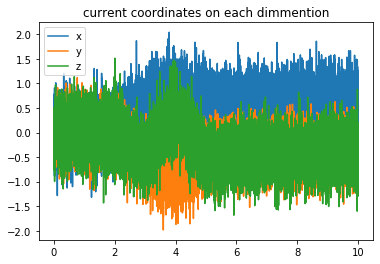

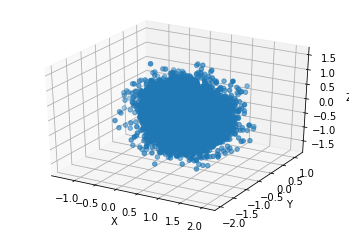

In [11]:
    plt.figure()
    plt.title(label= 'current coordinates on each dimmention')
    plt.plot(sim.trange(), sim.data[integrator_x_current_location_prob], label='x')
    plt.plot(sim.trange(), sim.data[integrator_y_current_location_prob], label='y')
    plt.plot(sim.trange(), sim.data[integrator_z_current_location_prob], label='z')
    plt.legend(loc="best");
    plt.show()

    X = sim.data[integrator_x_current_location_prob].ravel()
    Y = sim.data[integrator_y_current_location_prob].ravel()
    Z = sim.data[integrator_z_current_location_prob].ravel()

    s = np.dstack([X, Y, Z])
     
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z)
    # ax.plot(X, Y, Z, label='3D current coordinates')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()  



In [12]:
import numpy as np

# Generate some test data
data = s.reshape((5,2000,3))

# Write the array to disk
with open('current_coordinates.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(data.shape))
    outfile.write('# Array cols: X, Y, Z\n')

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in data:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 5 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.5f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')